<a href="https://colab.research.google.com/github/Yamina-Romani/microservices_identificaction_example/blob/main/CargoSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#@title Titre par défaut
import os
import string
import matplotlib
import matplotlib_inline
import numpy as np
import pandas as pd
import gensim.models
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics 
import pandas as pd


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:

#print('Indexing word vectors.')

embeddings_index = {}
f = open('/content/drive/My Drive/glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#print('Found %s word vectors.' % len(embeddings_index))

In [27]:
embeddings_dict={}
with open('/content/drive/My Drive/glove.6B.50d.txt','rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [28]:
nltk.download('stopwords')
nltk.download('wordnet')
#    stop words
stop_words = set(stopwords.words('english'))

# punctuation
punctuation = set(string.punctuation)

# lemmatization

lemmatization = WordNetLemmatizer()

def clean(documents):
    # split documents and remove stop words

    split_doc = " ".join([i for i in documents.lower().split() if i not in stop_words])

    # remove punctuation
    punc_doc = ''.join([j for j in split_doc if j not in punctuation])

    # normalize the text
    normalized = " ".join([lemmatization.lemmatize(word) for word in punc_doc.split()])

    return normalized


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# .........................getSynonyms using wordnet.................................................................................;
nltk.download('wordnet')
def getSynonyms(name):
    # print("name is " ,name)
    name = name.replace('_', ' ')
    syn = []
    ant = []
    for word in name.split():
        if word != "blc":
            for synset in wordnet.synsets(word):
                for lemma in synset.lemmas():
                    if (str(lemma.name()).lower() not in syn) and (str(lemma.name()).lower() != word) and (len(syn)<6):
                        syn.append(str(lemma.name()).lower())  # add the synonyms
                        if lemma.antonyms():  # When antonyms are available, add them into the list
                            ant.append(lemma.antonyms()[0].name())
    #  print('Synonyms: ' + str(syn))
    # print('Antonyms: ' + str(ant))
    return syn



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# ............Foreign keys......................................................................................................
def ObtainForeinKeys(lines):
    punc = '''!()-[]{};:'"\,<>.?@#$%^&=~'''

    listKeys = []
    Data = []
    for line in lines:
        doc = ''.join(ch for ch in line if ch not in punc)
        doc = doc.replace('|', ' ')
        Split_Doc = [word for word in doc.split() if word not in punc]
        if Split_Doc:
            Data.append(Split_Doc)

    i = 0
    for i in range(0, len(Data)):
        if (i in range(0, len(Data))) and (Data[i][0] == "Colonne"):
            Data.remove(Data[i])

        if (i in range(0, len(Data))) and (Data[i][0] == "Base"):
            Data.remove(Data[i])

        if (i in range(0, len(Data))) and (Data[i][0] == "Déchargement"):
            # print("i = ", i, "size = ",len(Data)," line ",Data[i])
            while (i in range(0, len(Data))) and (Data[i][0] != "Structure"):
                # print("\n line : ", Data[i])
                Data.remove(Data[i])

    cpt = 0
    list = []
    for doc in Data:

        if doc[0] == "Structure":
            i = 1
            if len(list) != 0:
                listKeys.append(list)
                list = []

            while doc[i] != "table":
                i = i + 1
            # print("cpt: ", cpt, " i : ", doc[i], " ", doc[i + 1])
            list.append(doc[i + 1])

        else:
            if "//**" not in doc[0] and ("Id" in doc[0] or "ID" in doc[0] or "id" in doc[0]):
                doc[0] = doc[0].replace("/", "")
                doc[0] = doc[0].replace("*", "")
                list.append(doc[0])

    return listKeys



In [31]:
# .........................Primary keys.............................................................................................
def ObtainPrimaryKeys(lines):
    punc = '''!()-[]{};:'"\,<>.?@#$%^&=~'''

    listKeys = []
    Data = []
    for line in lines:
        doc = ''.join(ch for ch in line if ch not in punc)
        doc = doc.replace('|', ' ')
        Split_Doc = [word for word in doc.split() if word not in punc]
        if Split_Doc:
            Data.append(Split_Doc)

    i = 0
    for i in range(0, len(Data)):
        if (i in range(0, len(Data))) and (Data[i][0] == "Colonne"):
            Data.remove(Data[i])

        if (i in range(0, len(Data))) and (Data[i][0] == "Base"):
            Data.remove(Data[i])

        if (i in range(0, len(Data))) and (Data[i][0] == "Déchargement"):
            # print("i = ", i, "size = ",len(Data)," line ",Data[i])
            while (i in range(0, len(Data))) and (Data[i][0] != "Structure"):
                # print("\n line : ", Data[i])
                Data.remove(Data[i])

    cpt = 0
    list = []
    for doc in Data:

        if doc[0] == "Structure":
            i = 1
            if len(list) != 0:
                listKeys.append(list)
                list = []

            while doc[i] != "table":
                i = i + 1
            # print("cpt: ", cpt, " i : ", doc[i], " ", doc[i + 1])
            list.append(doc[i + 1])

        else:
            if "//**" in doc[0]:
                doc[0] = doc[0].replace("/", "")
                doc[0] = doc[0].replace("*", "")
                list.append(doc[0])

    return listKeys



In [32]:
# ............................  Extract Symbols ..................................................................
def Extract(file_name):
    file='/content/drive/My Drive/'+file_name+'.txt'
    file = open(file, "r", encoding='UTF8')
    lines = file.readlines()
    file.close()
    ForeigKeys = []
    PrimaryKeys = []
    Tables_name = []
    PrimaryKeys = ObtainPrimaryKeys(lines)
    ForeigKeys = ObtainForeinKeys(lines)
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*~='''
    Data = []
    for line in lines:
        doc = ''.join(ch for ch in line if ch not in punc)
        doc = doc.replace('|', ' ')
        Split_Doc = [word for word in doc.split() if (word not in punc)]

        if Split_Doc:
            Data.append(Split_Doc)

    i = 0
    for i in range(0, len(Data)):
        if (i in range(0, len(Data))) and (Data[i][0] == "Colonne"):
            Data.remove(Data[i])

        if (i in range(0, len(Data))) and (Data[i][0] == "Base"):
            Data.remove(Data[i])

        if (i in range(0, len(Data))) and (Data[i][0] == "Déchargement"):
            # print("i = ", i, "size = ",len(Data)," line ",Data[i])
            while (i in range(0, len(Data))) and (Data[i][0] != "Structure"):
                # print("\n line : ", Data[i])
                Data.remove(Data[i])

    # ................. Extract Symbols ..................................

    # print("Data:")
    File_name = '/content/drive/My Drive/'+file_name+'_treat.txt'
    Synonyms = []
    TargetTable = []
    f = open(File_name, "w")
    for doc in Data:
        cpt = 0
        if doc[0] == "Structure":
            i = 1
            while doc[i] != "table":
                i = i + 1

            name = doc[i + 1]
            Tables_name.append(name)
            Synonyms = getSynonyms(name)
            
            f.write("\n" + doc[i + 1].replace('_', ' ') + " " + doc[i + 1].replace('_', ' ') + " " + doc[i + 1].replace('_',
                                                                                                                    ' ') + ": ")
            for s in Synonyms:
                f.write(s.replace('_', ' ') + ", ")
        else:
            if "ID" in doc[0] or "id" in doc[0] or "Id" in doc[0]:
                # print("tab = ", name)
                f.write(doc[0].replace('_', ' ').lower() + ", ")
                # if Foreign Key
                NoneSengletobFKey = False
                IsForeignKey = False
                for k in ForeigKeys:
                    #  print("k = ",k[0], "name = ",name)
                    if k[0] == name and doc[0] in k:
                        IsForeignKey = True
                    if k[0] != name and doc[0] in k:
                        NoneSengletobFKey = True

                PrimaryKey = False
                sourceTable = ""
                if IsForeignKey:  # is Foreign key
                    for k in PrimaryKeys:
                        if len(k) == 2 and k[1] == doc[0]:
                            sourceTable = k[0]
                        if len(k) > 2 and doc[0] in k:
                            PrimaryKey = True

                    # print( "key",doc[0] ,"Senelton = ", NoneSengletobFKey)
                    if not NoneSengletobFKey and not PrimaryKey and sourceTable != "":
                        for i in range(3):
                            f.write(doc[0].replace('_', ' ').lower() + ", " + doc[0].replace('_', ' ').lower() + ", ")
                            f.write(sourceTable.replace('_', ' ') + ", " + sourceTable.replace('_',
                                                                                               ' ') + ", " + sourceTable.replace(
                                '_', ' ') + ", ")
                    else:
                        if sourceTable != "":
                            for i in range(3):
                                f.write(doc[0].replace('_', ' ').lower() + ", ")
                                f.write(sourceTable.replace('_', ' ') + ", " + sourceTable.replace('_', ' ') + ", ")
                else:  # is not a foreign key

                    oneKey = False
                    twoKey = False
                    for k in PrimaryKeys:
                        if k[0] == name and len(k) == 2 and k[1] == doc[0]:
                            oneKey = True
                        if k[0] == name and len(k) > 2 and doc[0] in k:
                            twoKey = True
                    if oneKey:  # if one primary key
                        TargetTable = []
                        for k in PrimaryKeys:
                            if k[0] != name and doc[0] in k:
                                TargetTable.append(k[0])

                        for k in ForeigKeys:
                            if k[0] != name and doc[0] in k:
                                TargetTable.append(k[0])

                        # print('target tabel of ',name, " are: ",TargetTable)
                        if len(TargetTable) == 1:
                            for i in range(3):
                                f.write(
                                    TargetTable[0].replace('_', ' ') + ", " + TargetTable[0].replace('_', ' ') + ", " +
                                    TargetTable[0].replace('_', ' ') + ", ")
                        if len(TargetTable) > 1:
                            for i in range(len(TargetTable)):
                                for j in range(3):
                                    f.write(TargetTable[i].replace('_', ' ') + ", " + TargetTable[i].replace('_',
                                                                                                             ' ') + ", ")

                    if twoKey:  # if two primary key
                        SourceTable = ""
                        existInOthers = False
                        for k in PrimaryKeys:
                            if k[0] != name and len(k) == 2 and doc[0] in k:
                                SourceTable = k[0]
                            if k[0] != name and len(k) > 2 and doc[0] in k:
                                existInOthers = True
                        existFKey = False
                        for k in ForeigKeys:
                            if k[0] != name and doc[0] in k:
                                existFKey = True
                        if not existInOthers and not existFKey and SourceTable != "":
                            for i in range(3):
                                f.write(doc[0].replace('_', ' ').lower() + ", " + doc[0].replace('_', ' ').lower() + ", ")
                                f.write(SourceTable.replace('_', ' ') + ", " + SourceTable.replace('_',
                                                                                                   ' ') + ", " + SourceTable.replace(
                                    '_', ' ') + ", ")
                        else:
                            if SourceTable != "":
                                for i in range(3):
                                    f.write(doc[0].replace('_', ' ').lower() + ", ")
                                    f.write(SourceTable.replace('_', ' ') + ", " + SourceTable.replace('_', ' ') + ", ")

            else:
                f.write(doc[0].replace('_', ' ').lower() + ", ")

    f.close()
    information = []
    information.append(File_name)
    information.append(Tables_name)
    return information


In [33]:
nltk.download('omw-1.4')
name = input("The file name : ") 

information = []
information = Extract(name)
File = information[0]
Tabels_name = information[1]
corpus = open(File, "r")
#corpus=open('/content/drive/MyDrive/autoparts.txt',"r")
clean_documents = [clean(doc) for doc in corpus]

#print(clean_documents)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The file name : cargo


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
documents=[]
for doc in clean_documents:
   # print("doc = ",doc.split())
    documents.append(doc.split())
print(documents)
with open('/content/drive/My Drive/docs.txt', 'w') as writefile:
     for doc in documents:
         writefile.write(str(doc))

[[], ['cargo', 'cargo', 'cargo', 'lading', 'freight', 'load', 'loading', 'payload', 'shipment', 'tracking', 'id', 'handelling', 'event', 'handelling', 'event', 'handelling', 'event', 'handelling', 'event', 'handelling', 'event', 'handelling', 'event', 'handelling', 'event', 'handelling', 'event', 'handelling', 'event', 'origin', 'route', 'specification', 'id', 'route', 'specification', 'id', 'route', 'specification', 'id', 'route', 'specification', 'route', 'specification', 'route', 'specification', 'route', 'specification', 'id', 'route', 'specification', 'id', 'route', 'specification', 'route', 'specification', 'route', 'specification', 'route', 'specification', 'id', 'route', 'specification', 'id', 'route', 'specification', 'route', 'specification', 'route', 'specification', 'delivery', 'id', 'delivery', 'id', 'delivery', 'id', 'delivery', 'delivery', 'delivery', 'delivery', 'id', 'delivery', 'id', 'delivery', 'delivery', 'delivery', 'delivery', 'id', 'delivery', 'id', 'delivery', '

In [36]:

def calculate_Document_vector(document,j):

 
 vectors=[]

 for word in document:
     #print("word :", word)
     if(word in embeddings_index):
        vectors.append(embeddings_index[word])

 avearge_vector=[]
 
 #print("length = ",len(vectors))
 i=0
 for i in range(50):   
     mean=0
     for vect in vectors:
        mean=mean+vect[i]
        #print("doc",j, " i = ",i)

     avearge_vector.append(mean/len(vectors))

 return(avearge_vector)


     
matrix=[]

documents=[]
j=0
for doc in clean_documents:
    #print("doc = ",doc.split())
    j=j+1
    if(doc!=''):
      documents.append(doc.split())
      DocVector=calculate_Document_vector(doc.split(),j)
      #print(DocVector)
      matrix.append(DocVector)


#print("doucument's vectors :",matrix)   

with open('/content/drive/My Drive/docsVector.txt', 'w') as writefile:
     for v in matrix:
         writefile.write(str(v))

In [37]:
#print(matrix)


The namber of clusters : 9


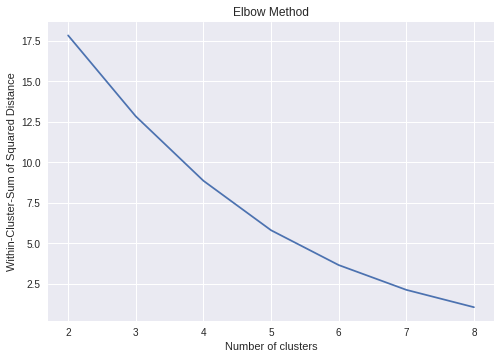

In [38]:

# .........................elbow method..................
wcss = []  # WCSS Scores = within-cluster-sum of squared distance
c=int(input("The namber of clusters : "))
clusters_1 = range(2, c)
for i in clusters_1:
    kmeans = KMeans(n_clusters=i, init='random', max_iter=600, n_init=100, algorithm="elkan",random_state=77)
    kmeans.fit(matrix)
    labels = kmeans.labels_
    result=davies_bouldin_score(matrix, labels)
  #  print( "metric davies_bouldin with  ","c =",i,"est: ", result)
    result=metrics.calinski_harabasz_score(matrix, labels)
   # print( "metric calinski_harabasz =  ","c =",i,"est: ", result)

    wcss.append(kmeans.inertia_)
plt.style.use("seaborn")
plt.plot(range(2, c), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster-Sum of Squared Distance')
plt.show()


In [39]:

# ........... ............. k means ............................................................................................
clusters = int((input("The namber of clusters : "))) # modified 

model = KMeans(n_clusters=clusters, init="k-means++", max_iter=300, n_init=30, algorithm="elkan", random_state=77)

model.fit(matrix)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]

# Getting the Centroids
centroids = kmeans.cluster_centers_
labels = model.labels_
result=davies_bouldin_score(matrix, labels)
print( "metric davies_bouldin =  ", result)
result=metrics.calinski_harabasz_score(matrix, labels)
print( "metric calinski_harabasz =  ", result)


#............Obtained Clusters..........................................................................................
obtainesCluster = []
for c in range(clusters):
    print(" Cluster", c)
    print("__________________________________________")
    count = 0
    cluseterI = []
    cluseterI.append(c)
    for i in labels:

        if i == c and count < len(Tabels_name):
            print("Table: ", Tabels_name[count], " ---> Document ", count)
            cluseterI.append(Tabels_name[count])
        count = count + 1

    obtainesCluster.append(cluseterI)
    print("__________________________________________")





The namber of clusters : 4
metric davies_bouldin =   0.9841065976475896
metric calinski_harabasz =   2.6773029500589676
 Cluster 0
__________________________________________
Table:  itinerary  ---> Document  4
Table:  leg  ---> Document  5
__________________________________________
 Cluster 1
__________________________________________
Table:  cargo  ---> Document  0
Table:  delivery  ---> Document  2
Table:  handelling_Event  ---> Document  3
Table:  Route_Specification  ---> Document  7
__________________________________________
 Cluster 2
__________________________________________
Table:  Carrier_Movement  ---> Document  1
Table:  voyage  ---> Document  8
__________________________________________
 Cluster 3
__________________________________________
Table:  location  ---> Document  6
__________________________________________
